# Lista de Exercícios 2: Métodos baseados em Diferenças Temporais

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps2.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 09/10/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Cliff Walking

Cliff Walking é um ambiente representado por um grid de tamanho $4 \times 12$, no qual um agente precisa atravessar o mapa do canto inferior esquerdo até o canto inferior direito, evitando um perigoso penhasco na parte inferior do mapa. O mapa do Cliff Walking pode ser visto no gif abaixo.

![Cliff Walking](https://gymnasium.farama.org/_images/cliff_walking.gif)

O agente sempre inicia na posição $(3, 0)$ e seu objetivo é alcançar a posição $(3, 11)$. As células das três primeiras linhas do grid (linhas $0$, $1$ e $2$) são seguras e o agente pode se mover livremente por elas. Já a linha $3$ contém um penhasco: todas as posições de $(3, 1)$ a $(3, 10)$ representam zonas de risco. Se o agente entrar em uma dessas células, ele cai do penhasco, o que encerra imediatamente o episódio com uma penalidade significativa. A cada passo, o agente recebe uma observação indicando sua posição atual (representada por um valor inteiro) e tem a possibilidade de escolher entre quatro ações possíveis: mover-se para cima, para baixo, para a esquerda ou para a direita. Cada movimento acarreta uma penalidade de $-1$, com exceção das quedas no penhasco, que resultam em uma penalidade severa de $-100$. Um episódio termina quando o agente alcança o objetivo final ou cai do penhasco. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

Nesta lista de exercícios, você irá trabalhar com o ambiente Cliff Walking descrito acima. Seu objetivo será implementar e analisar dois algoritmos baseados em diferenças temporais: Sarsa e Q-Learning.

---

## Sarsa

Sua primeira tarefa consiste em implementar um agente baseado no algoritmo Sarsa, que deverá seguir uma política $\varepsilon$-greedy. Para isso, utilize como referência o livro-texto da disciplina e os materiais discutidos em sala.

Você deverá concluir a implementação da classe `SarsaAgent` conforme as instruções abaixo:

1. Implemente o método `__init__` que inicializa um novo agente Sarsa. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
2. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
3. Implemente o método `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
4. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [1]:
import sys
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class SarsaAgent:
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        """
        Initializes the Sarsa Agent.

        This constructor sets up the agent's Q-table and internal parameters,
        ensuring the provided hyperparameters are valid and that the agent's
        behavior is reproducible.

        Args:
            observation_space: the env's observation space.
            action_space: the env's action space.
            alpha (float): the learning rate (step size), must be in (0, 1].
            gamma (float): the discount factor, must be in [0, 1].
            epsilon (float): the exploration rate for the epsilon-greedy policy, must be in [0, 1].
        """
        # Validate hyperparameters for robustness and safety.
        assert 0.0 < alpha <= 1.0, "Alpha must be in (0, 1]"
        assert 0.0 <= gamma <= 1.0, "Gamma must be in [0, 1]"
        assert 0.0 <= epsilon <= 1.0, "Epsilon must be in [0, 1]"

        # Store agent parameters.
        self.observation_space = observation_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize the Q-table with zeros. Arbitrary initialization
        # The shape is (num of states, num of actions).
        self.q_table = np.zeros((self.observation_space.n, self.action_space.n))

        # Use a dedicated random num generator for reproducibility.
        # This ensures that experiments can be repeated with the same random outcomes.
        self.rng = np.random.default_rng()

    def choose_action(self, state):
        """
        Selects an action for a given state using an epsilon-greedy policy.

        With prob epsilon, a random action is chosen (exploration).
        With prob 1-epsilon, the action with the highest Q-value is chosen (exploitation).

        Args:
            state (int): the current state observation.

        Returns:
            int: the chosen action.
        """
        # Exploration: choose a random action with prob epsilon.
        if self.rng.random() < self.epsilon:
            return self.action_space.sample()

        # Exploitation: choose the best-known action.
        else:
            # Find the maximum Q-value for the current state.
            max_q_value = np.max(self.q_table[state])

            # Identify all actions that have this maximum Q-value.
            # Randomly breaking ties prevents a deterministic bias in action selection.
            best_actions = np.where(self.q_table[state] == max_q_value)[0]

            # Return one of the best actions at random.
            return self.rng.choice(best_actions)

    def learn(self, state, action, reward, next_state, next_action):
        """
        Updates the Q-table using the Sarsa update rule.

        The update formula is:
        Q(S, A) <- Q(S, A) + alpha * [R + gamma * Q(S', A') - Q(S, A)]

        Args:
            state (int): the state S.
            action (int): the action A.
            reward (float): the reward R.
            next_state (int): the next state S'.
            next_action (int): the next action A'.
        """
        # Retrieve the Q-value for the current state-action pair.
        current_q = self.q_table[state, action]

        # Calculate the TD Target: R + gamma * Q(S', A').
        # If the next state is terminal, its Q-value is 0.
        next_q = self.q_table[next_state, next_action]
        td_target = reward + self.gamma * next_q

        # Calculate the TD Error: TD Target - Q(S, A).
        # The TD error measures the difference between the current estimate and a better one.
        td_error = td_target - current_q

        # Update the Q-value for the current state-action pair.
        self.q_table[state, action] += self.alpha * td_error

    def train(self, env, episodes):
        """
        Executes the Sarsa training loop for a specified num of episodes.

        This method orchestrates the agent-env interaction.

        Args:
            env: the Gymnasium env.
            episodes (int): the total num of episodes to run for training.

        Returns:
            tuple: a tuple containing:
                - np.ndarray: the final trained Q-table.
                - list: a list of total rewards obtained in each episode.
        """
        # List to store the sum of rewards for each episode.
        episode_returns = []

        # Main training loop over episodes.
        for _ in range(episodes):
            # Track the total reward for the current episode.
            total_reward = 0

            # Gymnasium's reset returns a tuple of (observation, info).
            state, _ = env.reset()

            # Choose the first action A from the starting state S.
            action = self.choose_action(state)

            terminated, truncated = False, False

            # Loop for each step of the episode until termination.
            while not (terminated or truncated):
                # Take action A, observe R and S'.
                next_state, reward, terminated, truncated, _ = env.step(action)

                # Update the episode's total reward.
                total_reward += reward

                # Choose the next action A' from the next state S'. Follows policy
                next_action = self.choose_action(next_state)

                # Update the Q-table based on the (S, A, R, S', A') experience.
                self.learn(state, action, reward, next_state, next_action)

                # Update state and action for the next iteration: S <- S', A <- A'.
                state = next_state
                action = next_action

            # Append the total reward for the completed episode.
            episode_returns.append(total_reward)

        # Return the learned Q-table and the episodic returns.
        return self.q_table, episode_returns

4. Agora, treine um novo agente Sarsa no ambiente Cliff Walking por 1000 episódios utilizando os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.9$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`.

In [3]:
env = gym.make("CliffWalking-v1")

# --- Define Hyperparameters and Env Details ---
alpha = 0.1      # Learning rate
gamma = 0.9      # Discount factor
epsilon = 0.1    # Exploration rate
episodes = 1000  # Num of training episodes

# Extract space dimensions from the env for agent initialization.
observation_space = env.observation_space
action_space = env.action_space


# --- Instantiate and Train the Sarsa Agent ---
sarsa_agent = SarsaAgent(
    observation_space=observation_space,
    action_space=action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)

# Run the training process and store the resulting Q-table and episodic returns.
sarsa_q_table, sarsa_returns = sarsa_agent.train(env, episodes)

env.close()

In [4]:
# Não altere ou remova esta célula

Nas células a seguir, analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Sarsa. Na última parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.

In [5]:
def print_greedy_policy(q_table):

    action_map = ['↑', '→', '↓', '←']
    q_table = np.array(q_table)

    if q_table.shape != (48, 4):
        raise ValueError("Q-table must have shape (48, 4)")

    for row in range(4):
        line = []
        for col in range(12):
            state = row * 12 + col
            if row == 3:
                char = (
                    action_map[np.argmax(q_table[state])] if col == 0 else
                    '◎' if col == 11 else
                    '▢'
                )
            else:
                char = action_map[np.argmax(q_table[state])]
            line.append(char)
        print(' '.join(line))

In [6]:
print_greedy_policy(sarsa_q_table)

→ → → → → → → → → → ↓ ↓
→ ↑ → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ → ← ↑ ↑ ↑ → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Q-Learning

Nesta atividade, você deverá implementar um agente baseado no algoritmo Q-learning, que também utiliza uma política $\varepsilon$-greedy para explorar o ambiente durante o treinamento. Novamente, utilize o livro-texto da disciplina e os materiais discutidos em sala de aula como referência.

Você deverá concluir a implementação da classe QLearningAgent, conforme as instruções a seguir:

5. Implemente o método `__init__` que inicializa um novo agente Q-Learning. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
6. Implemente a função `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
7. Implemente a função `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
8. Implemente o método `train`, que executa o loop de treinamento do algoritmo Q-Learning. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [7]:
class QLearningAgent:
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        """
        Initializes the Q-Learning Agent.

        This constructor sets up the agent's Q-table and internal parameters,
        ensuring the provided hyperparameters are valid and that the agent's
        behavior is reproducible.

        Args:
            observation_space: the env's observation space.
            action_space: the env's action space.
            alpha (float): the learning rate (step size), must be in (0, 1].
            gamma (float): the discount factor, must be in [0, 1].
            epsilon (float): the exploration rate for the epsilon-greedy policy, must be in [0, 1].
        """
        assert 0.0 < alpha <= 1.0, "Alpha must be in (0, 1]"
        assert 0.0 <= gamma <= 1.0, "Gamma must be in [0, 1]"
        assert 0.0 <= epsilon <= 1.0, "Epsilon must be in [0, 1]"

        self.observation_space = observation_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize the Q-table with zeros.
        self.q_table = np.zeros((self.observation_space.n, self.action_space.n))

        # Random number generator.
        self.rng = np.random.default_rng()

    def choose_action(self, state):
        """
        Selects an action for a given state using an epsilon-greedy policy.

        This method defines the agent's behavior policy. Balancing exploration and exploitation.

        Args:
            state (int): the current state observation.

        Returns:
            int: the chosen action.
        """
        # Exploration: with prob epsilon, choose a random action.
        if self.rng.random() < self.epsilon:
            return self.action_space.sample()

        # Exploitation: with prob 1-epsilon, choose the best-known action.
        else:
            # Find the maximum Q-value for the current state.
            max_q_value = np.max(self.q_table[state])

            # Identify all actions that share this maximum value and break ties randomly.
            best_actions = np.where(self.q_table[state] == max_q_value)[0]

            return self.rng.choice(best_actions)

    def learn(self, state, action, reward, next_state):
        """
        Updates the Q-table using the Q-learning (off-policy) update rule.

        The update formula is:
        Q(S, A) <- Q(S, A) + alpha * [R + gamma * max_a(Q(S', a)) - Q(S, A)]

        Args:
            state (int): the state S.
            action (int): the action A.
            reward (float): the reward R.
            next_state (int): the next state S'.
        """
        # Retrieve the Q-value for the current state-action pair.
        current_q = self.q_table[state, action]

        # Find the best possible Q-value for the next state (max_a Q(S', a)).
        # Off-policy update, using a greedy target policy.
        best_next_q = np.max(self.q_table[next_state])

        # Calculate the TD Target.
        td_target = reward + self.gamma * best_next_q

        # Calculate the TD Error.
        td_error = td_target - current_q

        # Update the Q-value for the current state-action pair.
        self.q_table[state, action] += self.alpha * td_error

    def train(self, env, episodes):
        """
        Executes the Q-Learning training loop for a specified num of episodes.

        This method orchestrates the agent-env interaction according to the
        Q-learning algorithm structure.

        Args:
            env: the Gymnasium env.
            episodes (int): the total num of episodes to run.

        Returns:
            tuple: a tuple containing:
                - np.ndarray: the final trained Q-table.
                - list: a list of total rewards obtained in each episode.
        """
        # List to store the sum of rewards for each episode.
        episode_returns = []

        # Main training loop.
        for _ in range(episodes):
            total_reward = 0

            # Initialize the episode.
            state, _ = env.reset()

            terminated, truncated = False, False

            # Loop for each step of the episode.
            while not (terminated or truncated):
                # Choose action A from S using the epsilon-greedy behavior policy.
                action = self.choose_action(state)

                # Take action A, observe R and S'.
                next_state, reward, terminated, truncated, _ = env.step(action)

                total_reward += reward

                # Update the Q-table using the off-policy Q-learning rule.
                self.learn(state, action, reward, next_state)

                # Update state for the next iteration: S <- S'.
                state = next_state

            episode_returns.append(total_reward)

        return self.q_table, episode_returns

9. Treine este novo agente por 1000 episódios no ambiente Cliff Walking. Utilize os mesmos parâmetros do exercício 4. Armazene a saída do método `train` nas variáveis `ql_q_table` e `ql_returns`.

In [8]:
env = gym.make("CliffWalking-v1")

# --- Define Hyperparameters and Env Details ---
alpha = 0.1      # Learning rate
gamma = 0.9      # Discount factor
epsilon = 0.1    # Exploration rate
episodes = 1000  # Number of training episodes

# Extract space dimensions from the env.
observation_space = env.observation_space
action_space = env.action_space

# --- Instantiate and Train the Q-Learning Agent ---
ql_agent = QLearningAgent(
    observation_space=observation_space,
    action_space=action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)

# Run the training process and store the results.
ql_q_table, ql_returns = ql_agent.train(env, episodes)

env.close()

In [9]:
# Não altere ou remova esta célula

Analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Q-Learning. Na próxima parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.


In [10]:
print_greedy_policy(ql_q_table)

→ → → → ↑ ↓ ↑ → → ↓ ↑ →
↑ ↑ → ↓ → → → ↓ → → → ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Análise

10. As políticas obtidas pelos agentes Sarsa e Q-learning apresentam diferenças significativas? Explique por que essas diferenças ocorrem - ou por que não ocorrem.

Sim, as políticas obtidas pelos agentes Sarsa e Q-learning apresentam diferenças significativas.


**Política de Q-learning (Caminho Ótimo - Guloso - off-policy)**: aprende o caminho mais curto possível para o objetivo, o que envolve mover-se diretamente ao longo da borda do penhasco. Esta é a verdadeira política ótima se o agente nunca cometer um erro. Entretanto, por não levar a política em consideração, a qual leva o risco de cair no penhasco em conta, está sujeito a cair no penhasco e tomar penalidade -100 devido ao e-epilson exploratório. Portanto, sua regra de atualização usa o **valor Q máximo possível** no próximo estado, **S'**, assumindo que uma ação gananciosa (ótima) será tomada, independentemente da ação que o agente realmente escolher em seguida. Ele aprende o valor da política ótima ($q_*$) diretamente, enquanto usa uma política diferente e mais exploratória para coletar recompensas. Isso torna o Q-learning "otimista" — ele ignora os riscos de sua própria estratégia de exploração e aprende o caminho teoricamente mais curto, mesmo que executar esse caminho com uma política gananciosa de $\epsilon$ leve a quedas ocasionais e custosas no penhasco.

**Política de Sarsa (Caminho Seguro - on-policy)**: aprende um caminho mais longo e seguro que se curva para cima, afastando-se do penhasco, antes de se mover em direção ao objetivo. Ele evita os estados imediatamente adjacentes ao penhasco. Leva em consideração os pesos da política, que por sua vez leva em consideração a probabilidade de cair no penhasco. Portanto, sua regra de atualização usa a ação, **A'**, que é *de fato selecionada* por sua própria política $\epsilon$-greedy no próximo estado, **S'**. Isso significa que Sarsa aprende o valor da política que está seguindo atualmente, incluindo seus próprios movimentos exploratórios (e potencialmente subótimos). Como a política $\epsilon$-greedy tem uma chance diferente de zero de selecionar a ação "para baixo" e cair no precipício, Sarsa aprende que estados próximos à borda do precipício são perigosos e têm baixo valor. Consequentemente, ele aprende uma política que dá ao penhasco uma ampla margem de manobra para maximizar as recompensas *sob seu próprio comportamento exploratório*.


11. Utilize a biblioteca *matplotlib* para construir um gráfico comparativo dos retornos episódicos obtidos pelos algoritmos Sarsa e Q-Learning. Utilize as variáveis `sarsa_returns` e `ql_returns` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Lembre-se de incluir título e legendas apropriadas para facilitar a interpretação dos dados.

**Importante:** O gráfico gerado deve se assemelhar ao exemplo abaixo. Embora os resultados dificilmente sejam idênticos, é fundamental que as tendências de cada algoritmo estejam bem evidentes. Caso os dados estejam muito ruidosos e dificultem a visualização das tendências, experimente aplicar uma média móvel ou outro método outro método de suavização de curvas. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

![Sarsa vs Q-Learning](sarsa-vs-qlearn.png)

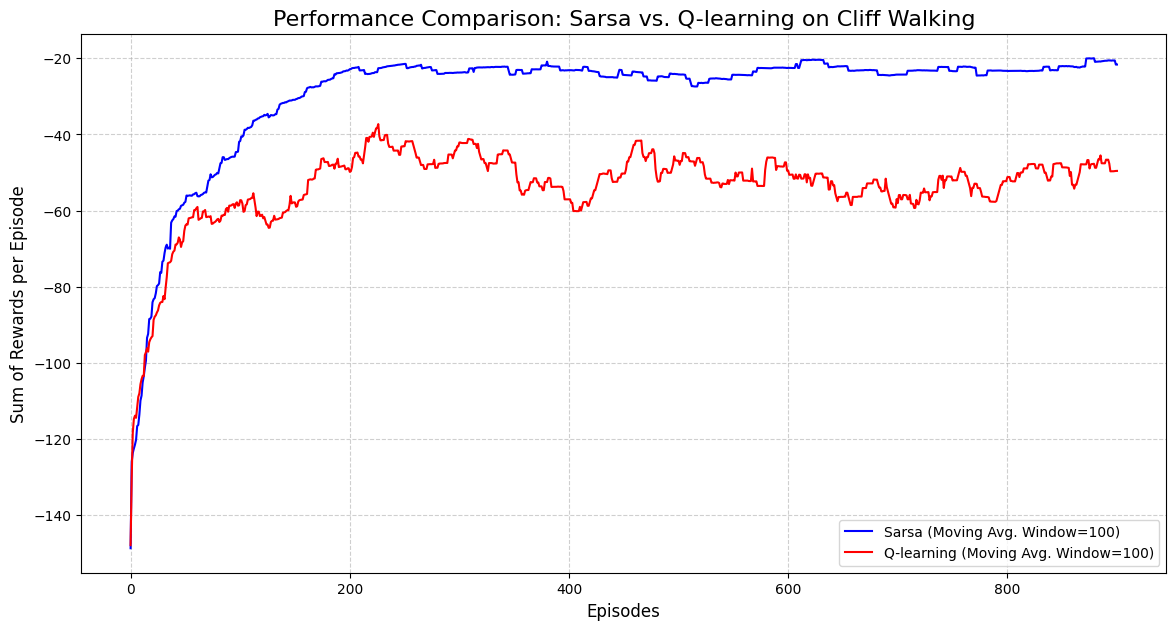

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    """Calculates the moving avg for a given list of data.
       doc: https://numpy.org/doc/2.1/reference/generated/numpy.convolve.html
    """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# --- Data Smoothing ---
# Applying a moving avg, noisy returns of raw episodic.
smoothing_window = 100
smoothed_sarsa_returns = moving_average(sarsa_returns, smoothing_window)
smoothed_ql_returns = moving_average(ql_returns, smoothing_window)

# --- Plot Generation ---
plt.figure(figsize=(14, 7))

# Plot the smoothed data for both algs.
plt.plot(smoothed_sarsa_returns, label=f'Sarsa (Moving Avg. Window={smoothing_window})', color='blue')
plt.plot(smoothed_ql_returns, label=f'Q-learning (Moving Avg. Window={smoothing_window})', color='red')

# Labels, title.
# Compares the on-policy (Sarsa) vs. off-policy (Q-learning)
plt.title('Performance Comparison: Sarsa vs. Q-learning on Cliff Walking', fontsize=16)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Sum of Rewards per Episode', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

12. Realize um novo treinamento do agente Sarsa, desta vez utilizando $\varepsilon = 0$, ou seja, adotando uma política puramente gulosa. Preserve todos os outros parâmetros utilizados anteriormente e armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`. Ao final do treinamento, observe a política aprendida.

In [12]:
env = gym.make("CliffWalking-v1")

# --- Define Hyperparameters for Greedy Sarsa ---
# For this run, we set epsilon to 0 to force a purely greedy policy.
# All other parameters remain the same as the initial training.
alpha = 0.1
gamma = 0.9
epsilon = 0.0  # Key change: No exploration
episodes = 1000

# Extract space dimensions from the env.
observation_space = env.observation_space
action_space = env.action_space

# --- Instantiate and Train the Greedy Sarsa Agent ---
# New SarsaAgent instance with the greedy policy setting.
sarsa_agent_greedy = SarsaAgent(
    observation_space=observation_space,
    action_space=action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)

# Run the training process.
sarsa_q_table_0_0, sarsa_returns_0_0 = sarsa_agent_greedy.train(env, episodes)

env.close()

print_greedy_policy(sarsa_q_table_0_0)

↑ ← → ↑ → → ← → → ↑ ↓ ↓
→ → → ← ↓ ↑ → → ← → → ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


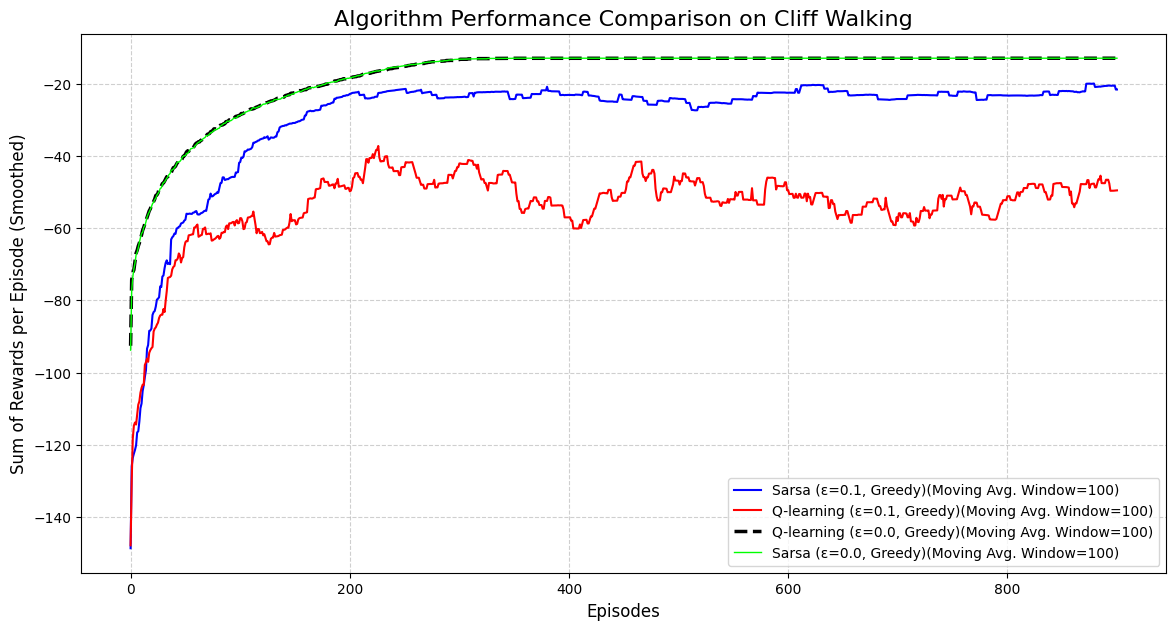

In [24]:

env = gym.make("CliffWalking-v1")

# --- Define Hyperparameters and Env Details ---
alpha = 0.1      # Learning rate
gamma = 0.9      # Discount factor
epsilon = 0.0    # Exploration rate
episodes = 1000  # Number of training episodes

# Extract space dimensions from the env.
observation_space = env.observation_space
action_space = env.action_space

# --- Instantiate and Train the Q-Learning Agent ---
ql_agent = QLearningAgent(
    observation_space=observation_space,
    action_space=action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)

# Run the training process and store the results.
ql_q_table_0_0, ql_returns_0_0 = ql_agent.train(env, episodes)

env.close()

# --- 4. Smooth and Plot the Results ---
smoothed_sarsa_0_0 = moving_average(sarsa_returns_0_0, smoothing_window)
smoothed_ql_0_0 = moving_average(ql_returns_0_0, smoothing_window)

plt.figure(figsize=(14, 7))

# Plot the smoothed data for both algs.
plt.plot(smoothed_sarsa_returns, label=f'Sarsa (ε=0.1, Greedy)(Moving Avg. Window={smoothing_window})', color='blue')
plt.plot(smoothed_ql_returns, label=f'Q-learning (ε=0.1, Greedy)(Moving Avg. Window={smoothing_window})', color='red')
plt.plot(smoothed_ql_0_0, label=f'Q-learning (ε=0.0, Greedy)(Moving Avg. Window={smoothing_window})', color='black', linestyle='--', linewidth=2.5)
plt.plot(smoothed_sarsa_0_0, label=f'Sarsa (ε=0.0, Greedy)(Moving Avg. Window={smoothing_window})', color='lime', linewidth=1)

# Add labels and title
plt.title('Algorithm Performance Comparison on Cliff Walking', fontsize=16)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Sum of Rewards per Episode (Smoothed)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [14]:
# Não altere ou remova esta célula

13. Quando o parâmetro de exploração $\varepsilon$ é fixado em zero para ambos algoritmos, o Sarsa torna-se equivalente ao Q-learning? Ambos selecionarão as mesmas ações e realizarão as mesmas atualizações de pesos?

Yes, when the exploration parameter **$\epsilon$ is fixed at zero**, the Sarsa algorithm becomes **equivalent to Q-learning**. Both algorithms will select the same actions and perform identical updates, assuming they start with the same initial Q-table.

---
## Detailed Explanation

The reason for this equivalence lies in how a purely greedy policy ($\epsilon = 0$) affects the core update rules of each algorithm.

### 1. Action Selection
With $\epsilon = 0$, the $\epsilon$-greedy policy becomes a **purely greedy policy**. Both agents will always choose the action with the maximum estimated Q-value for any given state. Therefore, if they have identical Q-tables, their action selection will be identical.

### 2. Weight Updates
The key difference between the algorithms lies in their update equations. Let's analyze them under a greedy policy.

* **Sarsa (On-Policy) Update Rule**:
    [cite_start]$Q(S, A) \leftarrow Q(S, A) + \alpha[R + \gamma Q(S', \boldsymbol{A'}) - Q(S, A)]$ [cite: 947]

    In this formula, **A'** is the action chosen in the next state **S'** *according to the policy*. Since the policy is now purely greedy, **A'** will be the action that maximizes the Q-value in state **S'**. In other words, $A' = \arg\max_{a} Q(S', a)$.

* **Q-learning (Off-Policy) Update Rule**:
    [cite_start]$Q(S, A) \leftarrow Q(S, A) + \alpha[R + \gamma \boldsymbol{\max_{a}Q(S', a)} - Q(S, A)]$ [cite: 1003]

When the Sarsa policy is greedy, the term $Q(S', A')$ becomes $Q(S', \arg\max_{a} Q(S', a))$, which is by definition the same as $\max_{a}Q(S', a)$.

Therefore, under this condition, the Sarsa update rule becomes identical to the Q-learning update rule. Because both the action selection and the weight update mechanisms become the same, the two algorithms are functionally equivalent.